<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/Fetal_Cns_Final_reg_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [173]:
# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [174]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [175]:

# Determine the available hardware (CPU or GPU) and set the PyTorch device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [176]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        pixel_size = torch.tensor(self.data_frame.iloc[idx, 1], dtype=torch.float32)
        hc = torch.tensor(self.data_frame.iloc[idx, 3], dtype=torch.float32)
        return image, pixel_size, hc

In [177]:
# Define transformations without cropping
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),  # Instead of cropping, just resize the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [178]:
# Hyperparameters
batch_size = 32
num_epochs = 8
step_size = 5
lr = 0.001

In [179]:
# File paths
root_dir = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"
train_csv = '/content/drive/MyDrive/FinalProject/train_data_filtered_90.csv'
val_csv = '/content/drive/MyDrive/FinalProject/val_data_filtered_5.csv'
test_csv = '/content/drive/MyDrive/FinalProject/test_data_filtered_5.csv'

In [180]:
# Load datasets
train_dataset = CustomDataset(csv_file=train_csv, root_dir=root_dir, transform=transform)
val_dataset = CustomDataset(csv_file=val_csv, root_dir=root_dir, transform=transform)
test_dataset = CustomDataset(csv_file=test_csv, root_dir=root_dir, transform=transform)


In [194]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

In [195]:
# Define the model
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        cnn_out_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()
        self.fc1 = nn.Linear(cnn_out_features + 1, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, image, pixel_size):
        x1 = self.cnn(image)
        x2 = pixel_size.view(-1, 1)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

In [196]:
# Initialize model, loss function, optimizer, and scheduler
model = CNNRegression().to(device)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [197]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

Epoch 1/8, Training Loss: 0.04852200434025791
Epoch 1/8, Validation Loss: 0.02841012366116047
Epoch 2/8, Training Loss: 0.003167371088811369
Epoch 2/8, Validation Loss: 0.0023130851914174855
Epoch 3/8, Training Loss: 0.002144411924139907
Epoch 3/8, Validation Loss: 0.0028637818759307265
Epoch 4/8, Training Loss: 0.0022616563688239288
Epoch 4/8, Validation Loss: 0.0020487587607931346
Epoch 5/8, Training Loss: 0.0014176493083747725
Epoch 5/8, Validation Loss: 0.0063930891919881105
Epoch 6/8, Training Loss: 0.0013550937098140519
Epoch 6/8, Validation Loss: 0.0009351756307296455
Epoch 7/8, Training Loss: 0.0009803367116816204
Epoch 7/8, Validation Loss: 0.0007886113307904452
Epoch 8/8, Training Loss: 0.0008928471199598991
Epoch 8/8, Validation Loss: 0.0006557486485689878


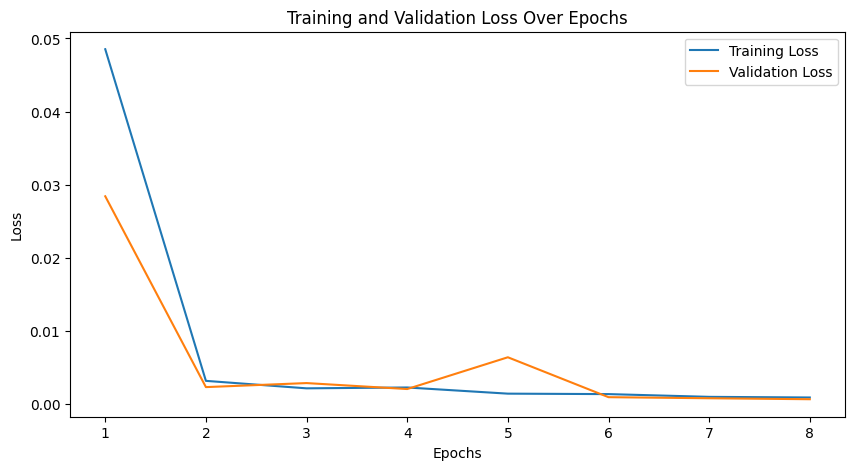

In [198]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, pixel_sizes, targets in train_loader:
        images, pixel_sizes, targets = images.to(device), pixel_sizes.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images, pixel_sizes)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, pixel_sizes, targets in val_loader:
            images, pixel_sizes, targets = images.to(device), pixel_sizes.to(device), targets.to(device)
            outputs = model(images, pixel_sizes)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

    scheduler.step()
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [199]:
def predict_head_circumference(image_path, pixel_size, model, min_hc, max_hc):
    try:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        pixel_size_tensor = torch.tensor([pixel_size], dtype=torch.float32).view(1, 1).to(device)

        with torch.no_grad():
            output = model(image_tensor, pixel_size_tensor)

        predicted_normalized_hc = output.item()
        predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc

        return predicted_hc

    except FileNotFoundError:
        print(f"Error: File {image_path} not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [200]:
# Ensure the min_hc and max_hc are defined
dataset = pd.read_csv('/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv')
min_hc = dataset['head circumference (mm)'].min()
max_hc = dataset['head circumference (mm)'].max()
test_csv_df = pd.read_csv(test_csv)
num_images_to_test = len(pd.read_csv(test_csv))
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1


train data =  /content/drive/MyDrive/FinalProject/train_data_filtered_90.csv
test data =  /content/drive/MyDrive/FinalProject/test_data_filtered_5.csv
batch size =  32
num_epochs =  8
step_size =  5
Results saved to /content/drive/MyDrive/FinalProject/results_30.7.csv
Total Images with Error < 5% of Ground Truth: 29
Percentage: 60.42%
Total Images with Error < 10% of Ground Truth: 40
Percentage: 83.33%
Image with the biggest absolute error:
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/779_2HC.png
Predicted Head Circumference: 232.2590789377689
Ground Truth Head Circumference: 288.16
Absolute Error: 55.900921062231134
Mean Squared Error: 186.84604019010445
Root Mean Squared Error: 13.669163843853232
Mean Absolute Error: 9.188372208147005
R² Score: 0.9436798774927582


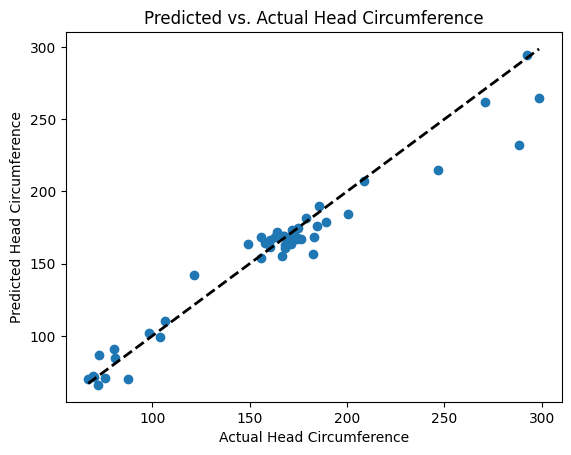

In [201]:
print("train data = ", train_csv)
print("test data = ", test_csv)
print("batch size = ", batch_size)
print("num_epochs = ", num_epochs)
print("step_size = ", step_size)

# Initialize lists to store true and predicted values
y_true = []
y_pred = []
results = []
absolute_errors = []
percentage_errors = []
counter = 0
percentage_error_counter_5 = 0  # Counter for errors less than 5%
percentage_error_counter_10 = 0  # Counter for errors less than 10%
threshold_param = 0.05  # Threshold for the ground truth circumference

# Variables to track the maximum absolute error and corresponding details
max_absolute_error = -1
max_error_image = ""
max_error_predicted = -1
max_error_ground_truth = -1

# Loop through the selected images
for idx in indices:
    image_name = test_csv_df.iloc[idx, 0]
    image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", image_name)
    ground_truth_circumference = test_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels
    pixel_size = test_csv_df.iloc[idx, 1]  # Assuming the second column contains the pixel size

    # Call the function to predict head circumference from the image
    predicted_circumference = predict_head_circumference(image_path, pixel_size, model, min_hc, max_hc)

    # Store the true and predicted values
    y_true.append(ground_truth_circumference)
    y_pred.append(predicted_circumference)

    # Calculate the absolute error
    absolute_error = abs(predicted_circumference - ground_truth_circumference)
    absolute_errors.append(absolute_error)

    # Calculate the percentage error
    percentage_error = (absolute_error / ground_truth_circumference) * 100
    percentage_errors.append(percentage_error)

    # Calculate the 5% and 10% thresholds for the ground truth circumference
    threshold_5 = 0.05 * ground_truth_circumference
    threshold_10 = 0.10 * ground_truth_circumference

    # Check if the absolute error is less than the 5% and 10% thresholds
    if absolute_error < threshold_5:
        percentage_error_counter_5 += 1
    if absolute_error < threshold_10:
        percentage_error_counter_10 += 1

    # Track the maximum absolute error
    if absolute_error > max_absolute_error:
        max_absolute_error = absolute_error
        max_error_image = image_path
        max_error_predicted = predicted_circumference
        max_error_ground_truth = ground_truth_circumference

    # Create the result string
    result_string = (f"Image: {image_path}\n"
                     f"Predicted Head Circumference: {predicted_circumference}\n"
                     f"Ground Truth Head Circumference: {ground_truth_circumference}\n"
                     f"Pixel Size: {pixel_size}\n"
                     f"Absolute Error: {absolute_error}\n"
                     f"Percentage Error: {percentage_error}%\n"
                     "****************************\n")

    # Append the result to the list
    results.append([image_name, result_string, absolute_error])

# Convert the results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results, columns=['Image', 'Result', 'Absolute Error'])
results_csv_path = "/content/drive/MyDrive/FinalProject/results_30.7.csv"
results_df.to_csv(results_csv_path, index=False)

# Print summary
print(f"Results saved to {results_csv_path}")
print(f"Total Images with Error < 5% of Ground Truth: {percentage_error_counter_5}")
print(f"Percentage: {percentage_error_counter_5 / num_images_to_test * 100:.2f}%")
print(f"Total Images with Error < 10% of Ground Truth: {percentage_error_counter_10}")
print(f"Percentage: {percentage_error_counter_10 / num_images_to_test * 100:.2f}%")

# Print the image with the biggest absolute error
print("Image with the biggest absolute error:")
print(f"Image: {max_error_image}")
print(f"Predicted Head Circumference: {max_error_predicted}")
print(f"Ground Truth Head Circumference: {max_error_ground_truth}")
print(f"Absolute Error: {max_absolute_error}")

# Calculate RMSE, MAE, and R²
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.scatter(y_true, y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.xlabel('Actual Head Circumference')
plt.ylabel('Predicted Head Circumference')
plt.title('Predicted vs. Actual Head Circumference')
plt.show()
